In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoTokenizer, AutoModel
import torch
from collections import Counter
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
tsv_file = "/content/drive/MyDrive/Data/interpress_news_category_tr_270k_train.tsv"
df = pd.read_csv(tsv_file, sep='\t')
df.head(10)

,Category,ID,PublishDateTime,CategoryCode,Content,Title
0,spor,301365715,2013-03-07T00:00:00Z,12,"NİANG, TAKIM ARKADAŞI FERNANDES E ÖVGÜLER YAĞD...",BİR SİHİRBAZ
1,teknoloji,402942743,2014-05-01T00:00:00Z,13,E-ticarette farklılaşmanın . .. anah...,E-TİCARETTE FARKLILAŞMANIN ANAHTARI
2,kultursanat,104111116,2010-12-02T00:00:00Z,6,"212 de şenlik 212 istanbul Povver Outlet, 3 Ar...",212'DE ŞENLİK
3,gida,411766475,2015-03-01T00:00:00Z,4,Geleceğe yeşeren tohumlar Botanist ve tarihçil...,GELECEĞE YEŞEREN TOHUMLAR
4,teknoloji,121672694,2011-04-01T00:00:00Z,13,1 nceleme Exper iasyPad P10AN syPad Türkiye n...,EXPER
5,bilisim,410666267,2015-01-12T00:00:00Z,1,"2015, E-DÖNÜSÜMÜN YILI OLACAK KEP, e-Defter, e...","2015, E-DÖNÜSÜMÜN YILI OLACAK"
6,seyahat,428842610,2017-02-01T00:00:00Z,10,"Mesta Restaurant & Bar, Ataşehir istanbul un g...","MESTA RESTAURANT & BAR, ATAŞEHİR"
7,ekonomi,306475921,2013-11-09T00:00:00Z,3,"Resesyon bitiyor büyüme başladı IRAK a, yılm i...",RESESYON BİTİYOR BÜYÜME BAŞLADI
8,siyasi,404505281,2014-07-11T00:00:00Z,11,"Başkan Fadıloğlu, iftar sonrası parkları dolaş...","BAŞKAN FADILOĞLU, İFTAR SONRASI PARKLARI DOLAŞTI"
9,gida,420085561,2016-02-01T00:00:00Z,4,X KARMA RESTORANLAR 360 İSTANBUL İstiklal Cad....,KARMA RESTORANLAR


In [4]:
texts = df['Content']
labels = df['CategoryCode']

In [ ]:
new_df = df.sample(n=10000, random_state=42) # Sample 10,000 random rows from the DataFrame
distribution = new_df['CategoryCode'].value_counts()
distribution

,count
CategoryCode,
14,820
12,736
11,723
16,707
0,678
2,673
1,671
13,641
3,615


In [ ]:
train_df, test_df = train_test_split(
    new_df,
    test_size=0.2,
    random_state=42,
    stratify=new_df['CategoryCode'] #Ensures the distribution of 'CategoryCode' is preserved across train and test sets

)

In [10]:
len_train = len(train_df)
len_test = len(test_df)

train_class_distribution = train_df['CategoryCode'].value_counts()
test_class_distribution = test_df['CategoryCode'].value_counts()

print(f"Train Dist: {train_class_distribution}, \n\nTest Dist: {test_class_distribution}, \n\nLEN: {len_train, len_test} \n\n")


Train Dist: CategoryCode
14    656
12    589
11    578
16    566
0     542
2     538
1     537
13    513
3     492
8     484
7     475
4     438
15    418
6     377
10    357
5     244
9     196
Name: count, dtype: int64, 

Test Dist: CategoryCode
14    164
12    147
11    145
16    141
0     136
2     135
1     134
13    128
3     123
8     121
7     119
4     109
15    105
6      94
10     89
5      61
9      49
Name: count, dtype: int64, 

LEN: (8000, 2000) 




In [11]:
embedding_models = {
    "bert": "dbmdz/bert-base-turkish-uncased",
    "minilm": "sentence-transformers/all-MiniLM-L12-v2",
    "gte": "thenlper/gte-large",
    "jina": "jinaai/jina-embeddings-v3",
    "bge": "BAAI/bge-m3"
}

In [12]:
classifiers = {
    "SVM": SVC(probability=True),
    "RF": RandomForestClassifier(),
    "MLP": MLPClassifier()
}

In [ ]:
import os

# Function to save embeddings as a .npy file
def save_embeddings(embeddings, file_name):
    np.save(file_name, embeddings)

# Function to load embeddings from a .npy file
def load_embeddings(file_name):
    return np.load(file_name)

In [14]:
device = torch.device("cuda")
device

device(type='cuda')

In [ ]:
# Function to generate embeddings from a text list using a pre-trained language model
def get_embeddings(texts, model_name, batch_size=32, max_length=512):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).to(device)
    model.eval()

    embeddings = []
    for i in range(0, len(texts), batch_size): # Process the input texts in batches
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(
            list(batch_texts),
            padding=True,
            truncation=True, # Truncate sequences longer than max_length
            max_length=max_length,
            return_tensors="pt" # Return PyTorch tensors
        ).to(device)
        with torch.no_grad(): # Disable gradient computation to save memory
            outputs = model(**inputs)
        embeddings.append(outputs.last_hidden_state.mean(dim=1).cpu().type(torch.float32).numpy()) # Compute mean embeddings across the sequence dimension (dim=1)
    return np.vstack(embeddings)

# Function to generate embeddings and save them to a file
def get_embeddings_and_save(texts, model_name, output_file, batch_size=32):
    embeddings = get_embeddings(texts, model_name, batch_size=batch_size)

    save_embeddings(embeddings, output_file)

    return embeddings


In [ ]:
# Initialize a dictionary to store predictions for each embedding model and classifier
all_predictions = {model_key: {clf_name: [] for clf_name in classifiers.keys()} for model_key in embedding_models.keys()}

for model_key, model_name in embedding_models.items():
    print(f"Processing embeddings for {model_name}...")

    train_file = f"{model_key}_train_embeddings.npy"
    test_file = f"{model_key}_test_embeddings.npy"

    # Check if embeddings exist; if not, generate and save them
    if not os.path.exists(train_file):
        train_embeddings = get_embeddings_and_save(train_df['Content'], model_name, train_file)
    else:
        train_embeddings = load_embeddings(train_file)

    if not os.path.exists(test_file):
        test_embeddings = get_embeddings_and_save(test_df['Content'], model_name, test_file)
    else:
        test_embeddings = load_embeddings(test_file)

    for clf_name, clf in classifiers.items(): # Loop through each classifier (SVM, RF, MLP)
        print(f"Training {clf_name} with {model_name} embeddings...")

        clf.fit(train_embeddings, train_df['CategoryCode'])
        predictions = clf.predict(test_embeddings)
        all_predictions[model_key][clf_name] = predictions # Store the predictions in the dictionary


Processing embeddings for dbmdz/bert-base-turkish-uncased...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/263k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Training SVM with dbmdz/bert-base-turkish-uncased embeddings...
Training RF with dbmdz/bert-base-turkish-uncased embeddings...
Training MLP with dbmdz/bert-base-turkish-uncased embeddings...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing embeddings for sentence-transformers/all-MiniLM-L12-v2...


tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Training SVM with sentence-transformers/all-MiniLM-L12-v2 embeddings...
Training RF with sentence-transformers/all-MiniLM-L12-v2 embeddings...
Training MLP with sentence-transformers/all-MiniLM-L12-v2 embeddings...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing embeddings for thenlper/gte-large...


tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

Training SVM with thenlper/gte-large embeddings...
Training RF with thenlper/gte-large embeddings...
Training MLP with thenlper/gte-large embeddings...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Processing embeddings for jinaai/jina-embeddings-v3...


tokenizer_config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


configuration_xlm_roberta.py:   0%|          | 0.00/6.54k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- configuration_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


modeling_lora.py:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

modeling_xlm_roberta.py:   0%|          | 0.00/49.9k [00:00<?, ?B/s]

embedding.py:   0%|          | 0.00/3.88k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- embedding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


block.py:   0%|          | 0.00/17.8k [00:00<?, ?B/s]

mlp.py:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mlp.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


mha.py:   0%|          | 0.00/34.4k [00:00<?, ?B/s]

rotary.py:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- mha.py
- rotary.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


stochastic_depth.py:   0%|          | 0.00/3.76k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- block.py
- mlp.py
- mha.py
- stochastic_depth.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


xlm_padding.py:   0%|          | 0.00/10.0k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_xlm_roberta.py
- embedding.py
- block.py
- xlm_padding.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/jinaai/xlm-roberta-flash-implementation:
- modeling_lora.py
- modeling_xlm_roberta.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.14G [00:00<?, ?B/s]

The repository for jinaai/jina-embeddings-v3 contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/jinaai/jina-embeddings-v3.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Training SVM with jinaai/jina-embeddings-v3 embeddings...
Training RF with jinaai/jina-embeddings-v3 embeddings...
Training MLP with jinaai/jina-embeddings-v3 embeddings...
Processing embeddings for BAAI/bge-m3...


tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

Training SVM with BAAI/bge-m3 embeddings...
Training RF with BAAI/bge-m3 embeddings...
Training MLP with BAAI/bge-m3 embeddings...


In [ ]:
from collections import defaultdict

# Function to determine the final prediction using majority vote with probabilities
def get_majority_vote_with_probabilities(votes, probabilities, classes):
    vote_counts = Counter(votes)
    most_common_votes = vote_counts.most_common()

    max_vote_count = most_common_votes[0][1]

    # Get the class labels with the highest vote count (candidates)
    candidates = [vote for vote, count in most_common_votes if count == max_vote_count]

    if len(candidates) == 1:
        return candidates[0]
    else:
        # If there's a tie, use the class probabilities to break the tie
        candidate_probs = {cls: probabilities[cls_idx] for cls_idx, cls in enumerate(classes) if cls in candidates}
        return max(candidate_probs, key=candidate_probs.get)

In [ ]:
representation_ensembles = {}
for model_key in embedding_models.keys():
    ensemble_predictions = []
    for i in range(len(test_df)):
        votes = [all_predictions[model_key][clf_name][i] for clf_name in classifiers.keys()]
        
        # Calculate the average class probabilities across classifiers for the current test sample
        probabilities = np.mean([classifiers[clf_name].predict_proba([test_embeddings[i]])[0] for clf_name in classifiers.keys()], axis=0)

        majority_vote = get_majority_vote_with_probabilities(votes, probabilities, classifiers["SVM"].classes_)
        ensemble_predictions.append(majority_vote)
    representation_ensembles[model_key] = ensemble_predictions


In [19]:
algorithm_ensembles = {}
for clf_name in classifiers.keys():
    ensemble_predictions = []
    for i in range(len(test_df)):
        votes = [all_predictions[model_key][clf_name][i] for model_key in embedding_models.keys()]
        probabilities = np.mean([classifiers[clf_name].predict_proba([test_embeddings[i]])[0] for model_key in embedding_models.keys()], axis=0)

        majority_vote = get_majority_vote_with_probabilities(votes, probabilities, classifiers["SVM"].classes_)
        ensemble_predictions.append(majority_vote)
    algorithm_ensembles[clf_name] = ensemble_predictions

In [ ]:
final_ensemble_predictions = []
for i in range(len(test_df)):
    votes = [
        all_predictions[model_key][clf_name][i]
        for model_key in embedding_models.keys()
        for clf_name in classifiers.keys()
    ]
    # Perform majority voting to determine the final prediction
    majority_vote = Counter(votes).most_common(1)[0][0]
    final_ensemble_predictions.append(majority_vote)

In [21]:
results_df = test_df.copy()
for model_key in embedding_models.keys():
    for clf_name in classifiers.keys():
        column_name = f"{model_key}_{clf_name}_prediction"
        results_df[column_name] = all_predictions[model_key][clf_name]

In [ ]:
# Add ensemble predictions for each embedding model to the results DataFrame
for model_key in embedding_models.keys():
    results_df[f"{model_key}_ensemble"] = representation_ensembles[model_key]

# Add ensemble predictions for each classifier to the results DataFrame
for clf_name in classifiers.keys():
    results_df[f"{clf_name}_ensemble"] = algorithm_ensembles[clf_name]
results_df["final_ensemble"] = final_ensemble_predictions

In [23]:
representation_f1_scores = {
    model_key: f1_score(test_df['CategoryCode'], representation_ensembles[model_key], average="weighted")
    for model_key in embedding_models.keys()
}
algorithm_f1_scores = {
    clf_name: f1_score(test_df['CategoryCode'], algorithm_ensembles[clf_name], average="weighted")
    for clf_name in classifiers.keys()
}
final_ensemble_f1_score = f1_score(test_df['CategoryCode'], final_ensemble_predictions, average="weighted")

representation_accuracy_scores = {
    model_key: accuracy_score(test_df['CategoryCode'], representation_ensembles[model_key])
    for model_key in embedding_models.keys()
}
algorithm_accuracy_scores = {
    clf_name: accuracy_score(test_df['CategoryCode'], algorithm_ensembles[clf_name])
    for clf_name in classifiers.keys()
}
final_ensemble_accuracy_score = accuracy_score(test_df['CategoryCode'], final_ensemble_predictions)


In [ ]:
individual_scores = []

for model_key in embedding_models.keys():
    for clf_name in classifiers.keys():
        y_true = test_df['CategoryCode']
        y_pred = all_predictions[model_key][clf_name]

        f1 = f1_score(y_true, y_pred, average="weighted")
        accuracy = accuracy_score(y_true, y_pred)

        individual_scores.append({
            "Model": model_key,
            "Classifier": clf_name,
            "F1 Score": f1,
            "Accuracy": accuracy
        })

individual_scores_df = pd.DataFrame(individual_scores)

print("\n--- Individual Model Results ---")
print(individual_scores_df)

individual_scores_df.to_csv("individual_model_results.csv", index=False)



--- Individual Model Results ---
     Model Classifier  F1 Score  Accuracy
0     bert        SVM  0.463191    0.4775
1     bert         RF  0.419171    0.4350
2     bert        MLP  0.440212    0.4380
3   minilm        SVM  0.330297    0.3380
4   minilm         RF  0.243147    0.2570
5   minilm        MLP  0.303271    0.3035
6      gte        SVM  0.389519    0.3975
7      gte         RF  0.283247    0.2970
8      gte        MLP  0.340231    0.3440
9     jina        SVM  0.508183    0.5170
10    jina         RF  0.389146    0.4030
11    jina        MLP  0.443005    0.4440
12     bge        SVM  0.464968    0.4790
13     bge         RF  0.386000    0.4015
14     bge        MLP  0.413068    0.4130


In [25]:
print("\n--- Results ---")
print("Representation Ensembles F1 Scores:", representation_f1_scores)
print("Representation Ensembles Accuracy Scores:", representation_accuracy_scores)

print("\nAlgorithm Ensembles F1 Scores:", algorithm_f1_scores)
print("Algorithm Ensembles Accuracy Scores:", algorithm_accuracy_scores)

print("\nFinal Ensemble F1 Score:", final_ensemble_f1_score)
print("Final Ensemble Accuracy Score:", final_ensemble_accuracy_score)


--- Results ---
Representation Ensembles F1 Scores: {'bert': 0.4853034167326846, 'minilm': 0.35973849540074687, 'gte': 0.4099783871782877, 'jina': 0.4946347335571976, 'bge': 0.4601089046512896}
Representation Ensembles Accuracy Scores: {'bert': 0.497, 'minilm': 0.366, 'gte': 0.42, 'jina': 0.505, 'bge': 0.4725}

Algorithm Ensembles F1 Scores: {'SVM': 0.4886797594999447, 'RF': 0.40842171447803166, 'MLP': 0.48330371506720415}
Algorithm Ensembles Accuracy Scores: {'SVM': 0.502, 'RF': 0.43, 'MLP': 0.49}

Final Ensemble F1 Score: 0.4943503742970672
Final Ensemble Accuracy Score: 0.5095


In [26]:
results_df.head()

,Category,ID,PublishDateTime,CategoryCode,Content,Title,bert_SVM_prediction,bert_RF_prediction,bert_MLP_prediction,minilm_SVM_prediction,...,bge_MLP_prediction,bert_ensemble,minilm_ensemble,gte_ensemble,jina_ensemble,bge_ensemble,SVM_ensemble,RF_ensemble,MLP_ensemble,final_ensemble
101765,aktuel,423328287,2016-06-01T00:00:00Z,0,(Alışveriş gezmesik Beta Şirketler Grubu nun s...,ALIŞVERİŞ GEZMESİ,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
93818,aktuel,301339488,2013-03-06T00:00:00Z,0,"FESra İLANI AVİVA SİGORTA A.Ş., Bağlarbaşı mah...",FESİH İLANI,3,14,16,11,...,0,3,11,3,0,0,3,14,0,3
173914,gida,414072597,2015-06-01T00:00:00Z,4,SEZON Mevsiminde yemek hayal oldu Mevsiminde ...,MEVSİMİNDE YEMEK HAYAL OLDU,2,2,2,15,...,0,2,15,0,4,4,4,4,4,4
171312,ticaret,426428834,2016-11-02T00:00:00Z,14,Tefeci Bankalar Dizginlenmeliydi KOBİDER Başka...,TEFECİ BANKALAR DİZGİNLENMELİYDİ,3,14,14,3,...,3,14,3,3,14,3,3,14,14,3
173511,teknoloji,421812011,2016-04-01T00:00:00Z,13,APMA MAXHZ LEOPARD 1 0AoKAnpco8nK etoi n apxiK...,APMA MAXHZ LEOPARD 1,13,13,13,13,...,13,13,13,9,13,13,13,13,13,13


In [27]:
results_df.to_csv("results_second.csv")

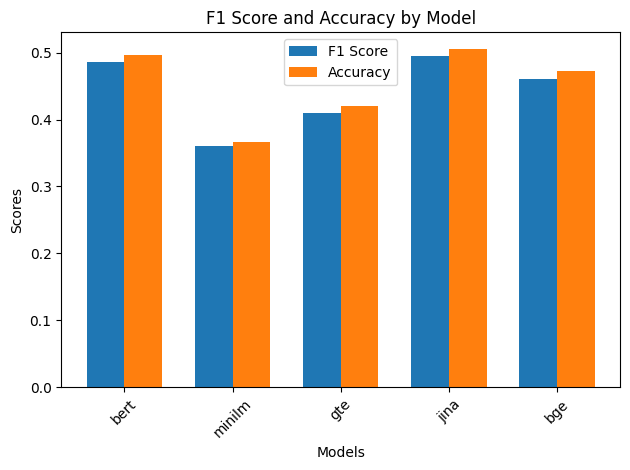

In [ ]:
models = list(representation_f1_scores.keys())
f1_scores = list(representation_f1_scores.values())
accuracy_scores = list(representation_accuracy_scores.values())

x = np.arange(len(models))  
width = 0.35 

fig, ax = plt.subplots()
ax.bar(x - width/2, f1_scores, width, label='F1 Score')
ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('F1 Score and Accuracy by Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

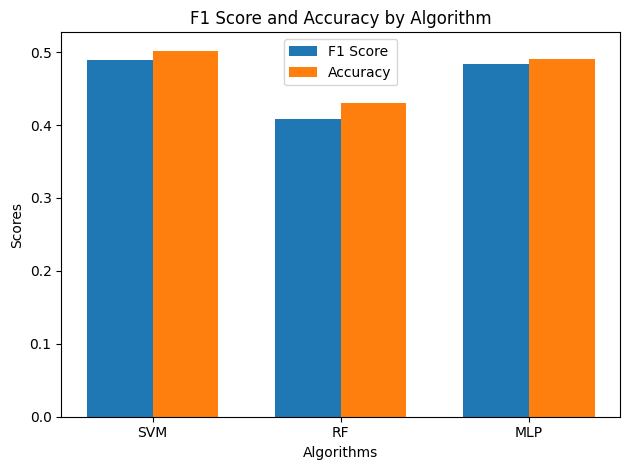

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

algorithms = list(algorithm_f1_scores.keys())
f1_scores = list(algorithm_f1_scores.values())
accuracy_scores = list(algorithm_accuracy_scores.values())

x = np.arange(len(algorithms)) 
width = 0.35  

fig, ax = plt.subplots()
ax.bar(x - width/2, f1_scores, width, label='F1 Score')
ax.bar(x + width/2, accuracy_scores, width, label='Accuracy')


ax.set_xlabel('Algorithms')
ax.set_ylabel('Scores')
ax.set_title('F1 Score and Accuracy by Algorithm')
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend()

plt.tight_layout()
plt.show()


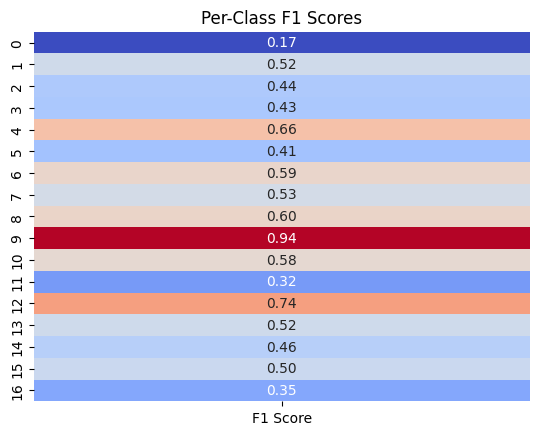

In [ ]:
from sklearn.metrics import classification_report
import seaborn as sns

report = classification_report(test_df['CategoryCode'], final_ensemble_predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

class_f1_scores = report_df.loc[report_df.index[:-3], 'f1-score']

sns.heatmap(class_f1_scores.values.reshape(-1, 1), annot=True, fmt='.2f', cmap='coolwarm', cbar=False,
            yticklabels=class_f1_scores.index, xticklabels=['F1 Score'])
plt.title('Per-Class F1 Scores')
plt.show()


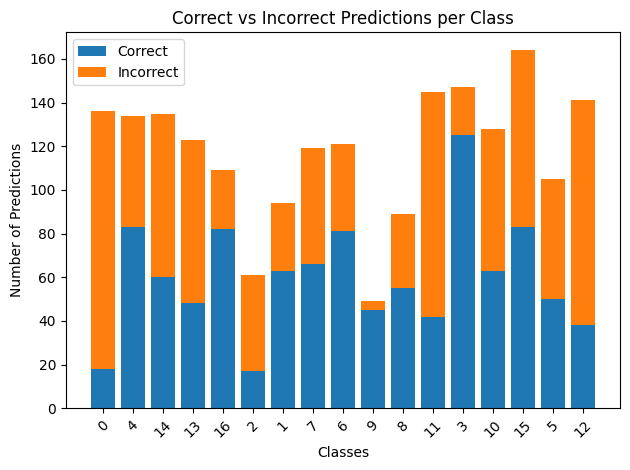

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df['CategoryCode'], final_ensemble_predictions)

correct = np.diag(cm)
total = cm.sum(axis=1)
incorrect = total - correct

x = np.arange(len(correct))

plt.bar(x, correct, label='Correct')
plt.bar(x, incorrect, bottom=correct, label='Incorrect')

plt.xlabel('Classes')
plt.ylabel('Number of Predictions')
plt.title('Correct vs Incorrect Predictions per Class')
plt.xticks(x, test_df['CategoryCode'].unique(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


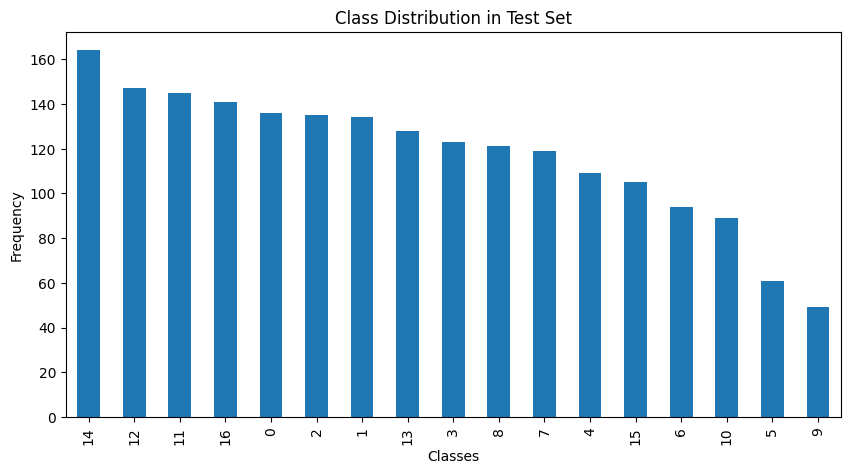

In [32]:
distribution = test_df['CategoryCode'].value_counts()
distribution.plot(kind='bar', figsize=(10, 5))
plt.title("Class Distribution in Test Set")
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.show()


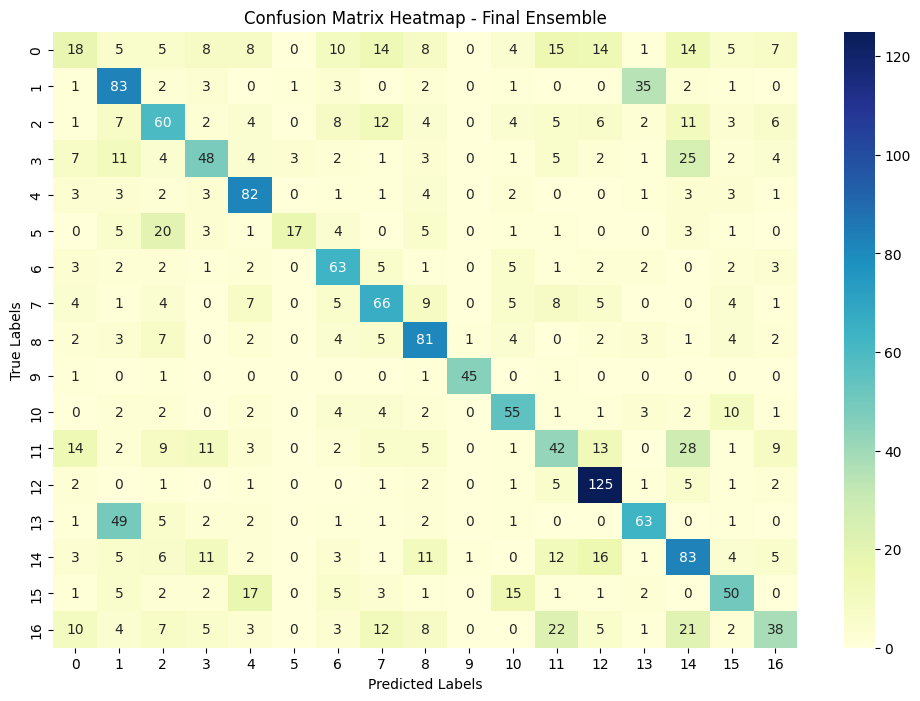

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_df['CategoryCode'], final_ensemble_predictions)

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(test_df['CategoryCode']), yticklabels=np.unique(test_df['CategoryCode']))
plt.title("Confusion Matrix Heatmap - Final Ensemble")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


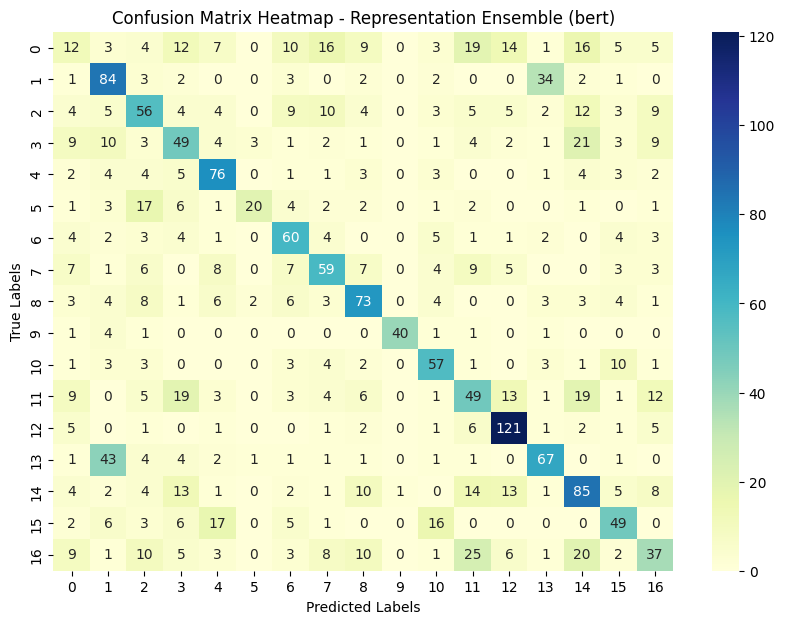

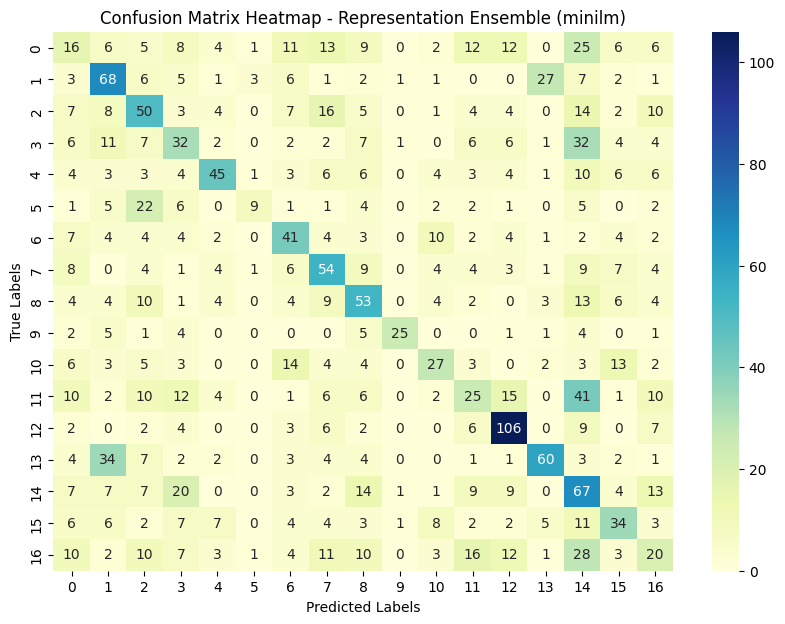

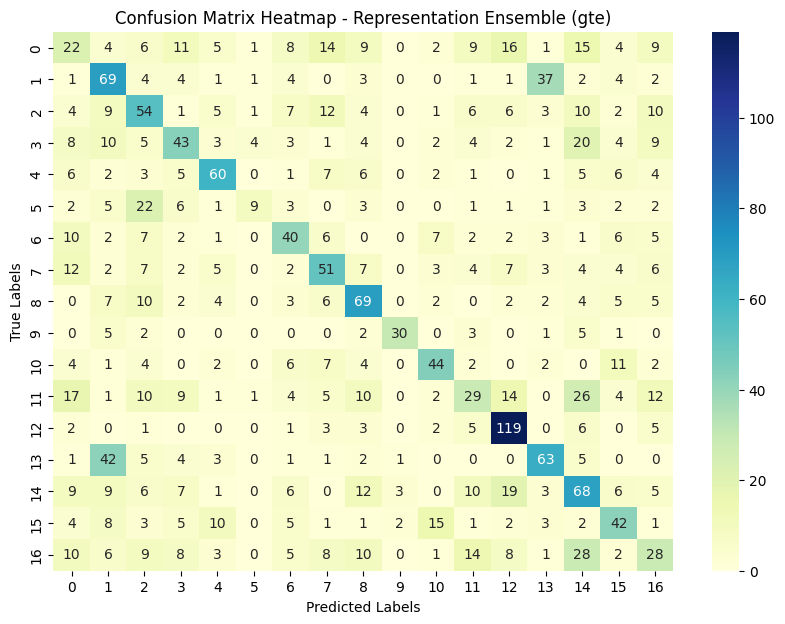

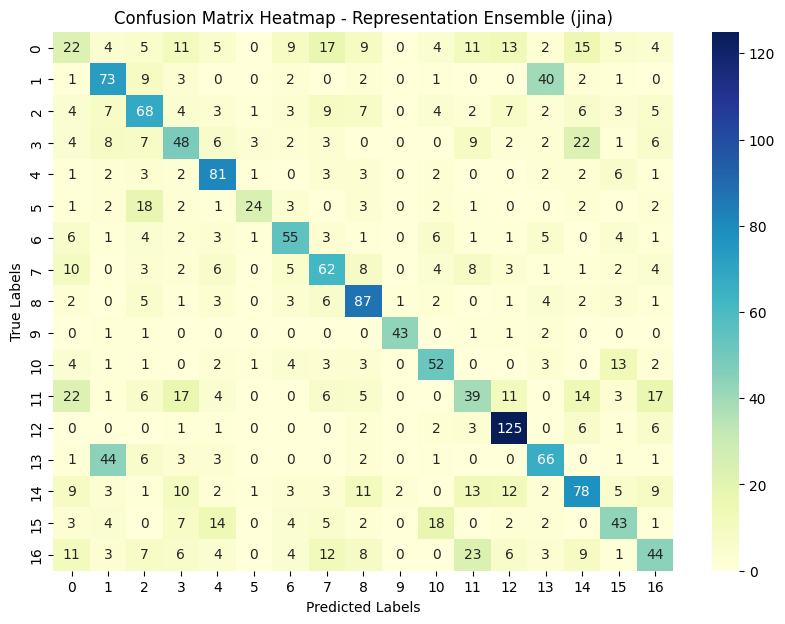

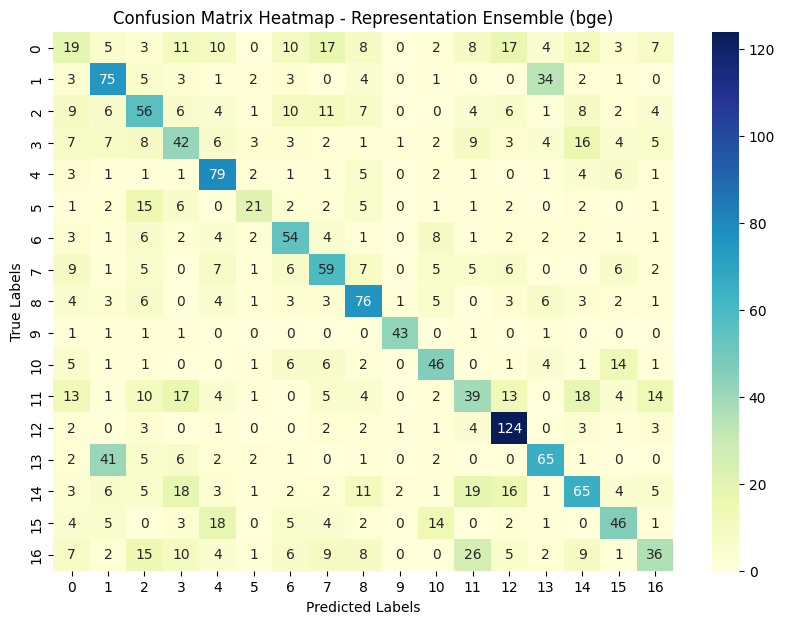

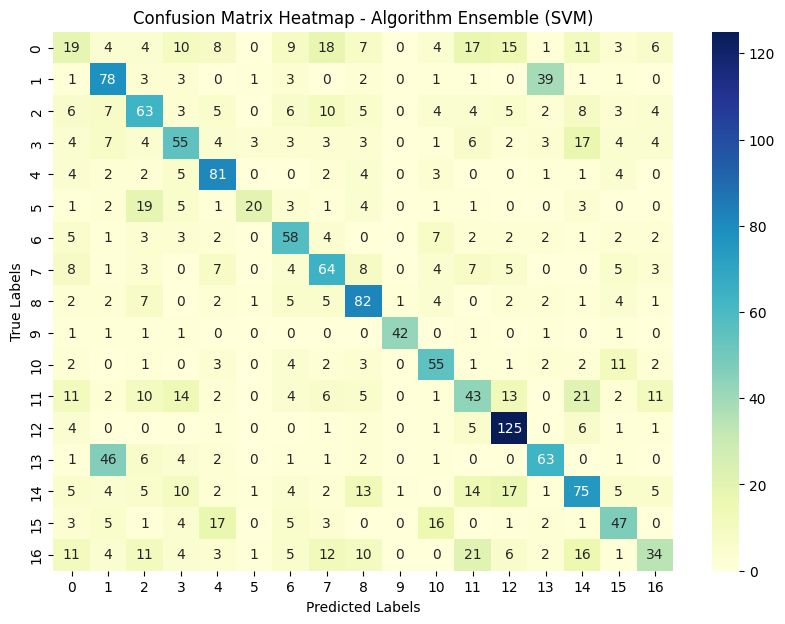

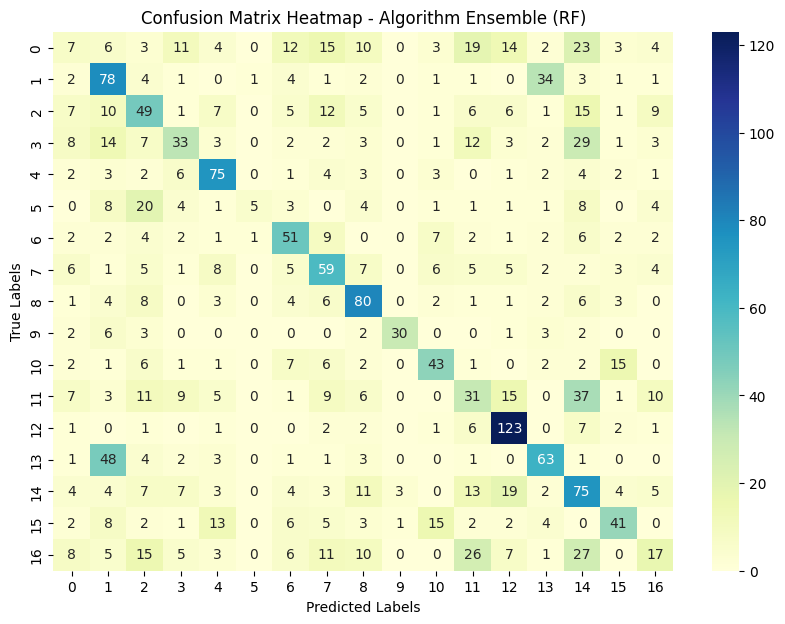

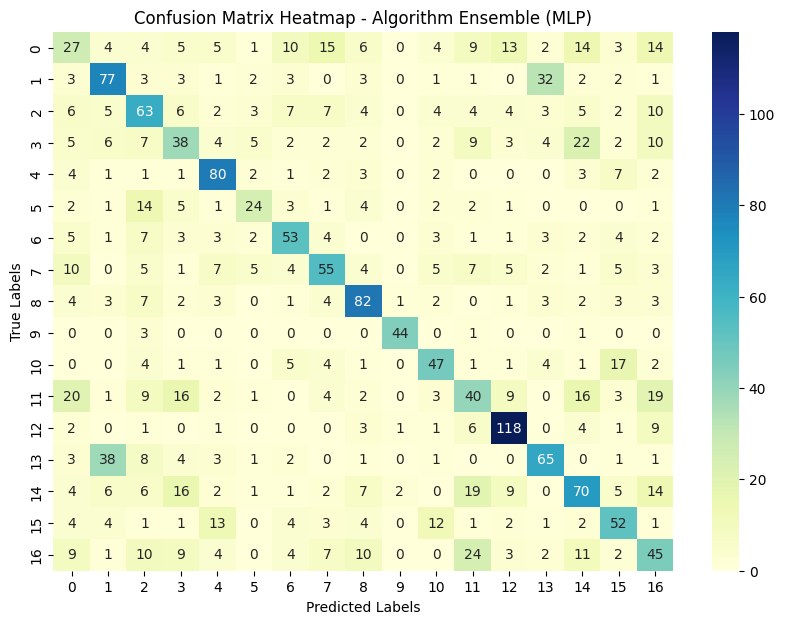

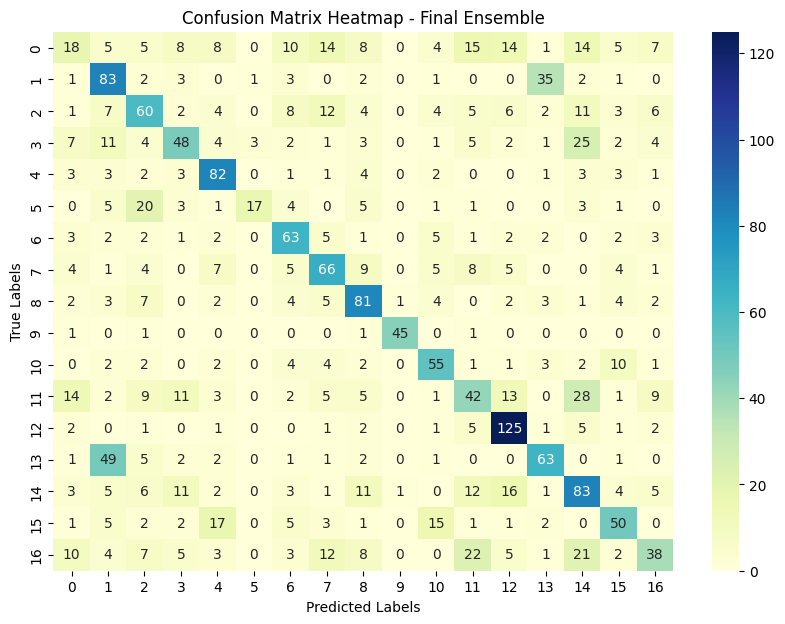

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix_heatmap(true_labels, predicted_labels, title):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Representation Ensemble Confusion Matrix
for model_key, predictions in representation_ensembles.items():
    plot_confusion_matrix_heatmap(
        test_df['CategoryCode'],
        predictions,
        title=f"Confusion Matrix Heatmap - Representation Ensemble ({model_key})"
    )

# Algorithm Ensemble Confusion Matrix
for clf_name, predictions in algorithm_ensembles.items():
    plot_confusion_matrix_heatmap(
        test_df['CategoryCode'],
        predictions,
        title=f"Confusion Matrix Heatmap - Algorithm Ensemble ({clf_name})"
    )

# Final Ensemble Confusion Matrix
plot_confusion_matrix_heatmap(
    test_df['CategoryCode'],
    final_ensemble_predictions,
    title="Confusion Matrix Heatmap - Final Ensemble"
)
